# Capstone Project - Battle of Neighborhoods

## Table of contents
1. [Introduction: Business Problem](#introduction)
2. [Data](#data)
3. [Methodology](#methodology)
4. [Analysis](#analysis)
5. [Results and Discussion](#results)
6. [Conclusion](#conclusion)


## 1. Introduction: Business Problem <a name="introduction"></a>

The objective of this project is to use readily available data about Bristol, like post codes, geo spatial codes, top venues etc to explore the city, segment and cluster its various post code areas and help identify a suitable place to open a Hotel Business. <br />
Bristol is one of the UK's most popular tourist destinations. The city is steeped in history and the historical and heritage sites are very popular among tourists. World famous Festivals and regular sporting events also draw lot of tourists to this city.<br />
According to the British Hospitality Association (BHA), the hospitality industry now supports more than 2.7 million people.
Total combined turnover for the hotel industry is estimated to be excess of £40bn (of £127bn tourist economy).By 2025 this figure is forecast by accountancy firm Deloitte to rise to £257bn, which is around 10% of the UK's GDP.<br />
Based on this background, opening a hotel in this city looks like a good business proposition. If a hotel chain wants to open its new hotel or a startup is trying to open their first hotel, this project will aim to provide recommendation on best place to open one.


## 2. Data <a name="data"></a>

To identify various post codes and cluster them we will be using the following data:

* List of Post codes and their coverage - This will define the area/city in scope for this project which is Bristol, UK. Wikipedia will be used to source this data. This page has a table with Post code districts, Post town, their coverage and the Local authority area. Python’s Beautifulsoup package will be used to scrape data from this page.
* Latitude and Longitude co-ordinates of these post codes which will be used to plot the map and also to get the popular venues list. This can either be found using Python’s Geocoder package or pulled from a compiled list readily available on various sites. 2-Outcode file from the link was used to get the co-ordinate details for Bristol.
* Venue data will be used to perform clustering of the post code areas - Foursquare is a location technology platform which has one of the largest data of over 105 million+ locations and is used by over 150k developers. Explore function of this API will be used to get the most common venue categories in each post code, and then use this feature to group the various post codes of Bristol into clusters. K-means will be used to cluster the various post codes based on similarity to gain insights.


### Get list of postcodes from wikipedia

In [8]:
#Import all libraries required
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests  # library to handle requests
import folium # map rendering library
from bs4 import BeautifulSoup
#import geocoder
# import k-means from clustering stage
from sklearn.cluster import KMeans

We will use BeautifulSoup to scrape the post code details from a table in Wikipedia page. We will start by reading data from page into soup

In [9]:
source = requests.get('https://en.wikipedia.org/wiki/BS_postcode_area').text
soup = BeautifulSoup(source, 'lxml')

We will then search for table within the data and identify the columns

In [10]:
cols=[]
table=soup.find('table', class_="wikitable sortable")
#table=soup.find_all('table')[1]
table_headers=table.find_all('th')[0:4]
for th in table_headers:
    cols.append(th.text.rstrip('\n'))
cols

['Postcode district', 'Post town', 'Coverage', 'Local authority area']

We will then read all the records in the table

In [11]:
records=[]
table_rows=table.find_all('tr')[1:]
for tr in table_rows:
    td=tr.find_all('td')
    th=tr.find_all('th')
    if td!=[]:
        row=[j.text.rstrip('\n') for j in th]
        row.extend([i.text.rstrip('\n') for i in td])
        records.append(row)

records and columns read earlier will then be put into a dataframe

In [12]:
df=pd.DataFrame(records, columns=cols)

Cleaning dataframe to remove rows with blank coverage

In [13]:
df = df.replace('', np.nan)
df.dropna(subset=['Coverage'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

Let us look at the dataframe

In [14]:
df.head()

,Postcode district,Post town,Coverage,Local authority area
0,BS1,BRISTOL,"Bristol city centre, Redcliffe",Bristol
1,BS2,BRISTOL,"Kingsdown, St Paul's, St Phillip's, St Agnes",Bristol
2,BS3,BRISTOL,"Bedminster, Southville, Bower Ashton, part of ...",Bristol
3,BS4,BRISTOL,"Brislington, Knowle, Knowle West, St Anne's, p...",Bristol
4,BS5,BRISTOL,"Easton, St George, Redfield, Whitehall, Eastvi...",Bristol


We have pulled the post code, post town, Coverage area and local authority area from the wikipedia page

Let us check the number of rows in the dataframe

In [15]:
df.shape

(37, 4)

Now, we can get the latitude and logitude details into a dataframe using the spreadsheet provided in the link [here](https://www.theinformationlab.co.uk/2011/03/14/hopefully-the-last-word-on-uk-postcode-mapping-in-tableau/). I have already loaded the data file into the project here for ease of use. Below we will load it into a dataframe.

In [1]:
# The code was removed by Watson Studio for sharing.

,Postcode district,Latitude,Longitude
0,BS1,51.453524,-2.593325
1,BS2,51.460004,-2.581900
2,BS3,51.438606,-2.603060
3,BS4,51.435552,-2.563445
4,BS5,51.462045,-2.551874


We can then merge the two dataframes into one dataframe that has both the post codes and geospatial data

In [16]:
df_latlong=pd.merge(df,df_data_1,on='Postcode district')
df_latlong.head()

,Postcode district,Post town,Coverage,Local authority area,Latitude,Longitude
0,BS1,BRISTOL,"Bristol city centre, Redcliffe",Bristol,51.453524,-2.593325
1,BS2,BRISTOL,"Kingsdown, St Paul's, St Phillip's, St Agnes",Bristol,51.460004,-2.581900
2,BS3,BRISTOL,"Bedminster, Southville, Bower Ashton, part of ...",Bristol,51.438606,-2.603060
3,BS4,BRISTOL,"Brislington, Knowle, Knowle West, St Anne's, p...",Bristol,51.435552,-2.563445
4,BS5,BRISTOL,"Easton, St George, Redfield, Whitehall, Eastvi...",Bristol,51.462045,-2.551874


Let us create a folium map of Bristol and superimpose the coverage areas. Use geopy library to get the latitude and longitude details of Bristol. We can use this to create a map of the city using folium

In [17]:
address = 'Bristol, UK'

geolocator = Nominatim(user_agent="Br_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bristol are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bristol are 51.4538022, -2.5972985.


Use co-ordinates to create a folium map centred on Bristol with post codes and coverage area superimposed on it

In [18]:
# create map of Bristol using latitude and longitude values
map_bristol_init = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lon, poi, cov in zip(df_latlong['Latitude'], df_latlong['Longitude'], df_latlong['Postcode district'], df_latlong['Coverage']):
    label = '{}, {}'.format(poi, cov)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_bristol_init)
map_bristol_init       

Foursquare credentials

In [20]:
# The code was removed by Watson Studio for sharing.

Now, we can get top 100 venues in each of the coverage areas within a radius of 1000 meters. We will begin by creating a function that pulls the venues based on coverage area details

In [21]:
def getNearbyVenues(post, posttown, coverage, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for pst, pt, cv, lat, lng in zip(post, posttown, coverage, latitudes, longitudes):
        #print(cv)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            pst, 
            pt,
            cv, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode district', 
                  'Post town',
                  'Coverage', 
                  'Coverage Latitude', 
                  'Coverage Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Use above function to get the venue details into a dataframe

In [22]:
bristol_venues = getNearbyVenues(post=df_latlong['Postcode district'],
                                   posttown=df_latlong['Post town'],
                                   coverage=df_latlong['Coverage'],
                                   latitudes=df_latlong['Latitude'],
                                   longitudes=df_latlong['Longitude']
                                  )

Let us check the number of venues returned for the entire city

In [23]:
bristol_venues.shape

(824, 9)

In [24]:
#Sample rows
bristol_venues.head()

,Postcode district,Post town,Coverage,Coverage Latitude,Coverage Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BS1,BRISTOL,"Bristol city centre, Redcliffe",51.453524,-2.593325,Small Street Espresso,51.454766,-2.594400,Coffee Shop
1,BS1,BRISTOL,"Bristol city centre, Redcliffe",51.453524,-2.593325,Small Bar,51.451791,-2.594948,Pub
2,BS1,BRISTOL,"Bristol city centre, Redcliffe",51.453524,-2.593325,St. Nicholas Market,51.454248,-2.593286,Market
3,BS1,BRISTOL,"Bristol city centre, Redcliffe",51.453524,-2.593325,BrewDog Bristol,51.453659,-2.592372,Beer Bar
4,BS1,BRISTOL,"Bristol city centre, Redcliffe",51.453524,-2.593325,Full Court Press Specialty Coffee,51.455157,-2.593258,Coffee Shop


We now have 824 rows of venue details corresponding to various post codes in Bristol. 
Let us find the number of unique venue categories in the returned data set

In [25]:
print('There are {} unique venue categories.'.format(len(bristol_venues['Venue Category'].unique())))

There are 149 unique venue categories.


## 3. Methodology <a name="methodology"></a>

These steps will be followed in this project to find similarity in the neighborhood/coverage areas of Bristol.  
1. Firstly Wikipedia page will be scraped to get all the Post code areas and their Coverage areas
2. Using the spreadsheet downloaded from site, identify Latitude and Longitude details of each of the post code areas
3. Use Foursquare API to get venues data around each of these post code areas.<br /> First 3 steps are already covered in the previous data section. We will need to follow below 4 steps as part of analysis section.
4. Analyse this list to understand number of venues by each post code and also number of hotels within each area
5. Use K-means clustering to perform clustering on the venue data using best k value
6. Then finally display the clusters by overlaying them on Bristol Map using Folium and examine the clusters


## 4. Analysis <a name="analysis"></a>

We will start by grouping the venues by the post code to get an idea of the number of venues returned for each post code

In [26]:
bristol_venues_count=bristol_venues.groupby('Postcode district').size().reset_index(name='count_venue').sort_values('count_venue', ascending=False)


Let us check the count of venues returned for each post code

In [27]:
bristol_venues_count

,Postcode district,count_venue
0,BS1,100
7,BS2,100
33,BS6,94
35,BS8,84
18,BS3,74
11,BS23,55
25,BS37,30
34,BS7,28
32,BS5,19
27,BS4,18


This gives our count of venues returned by foursquare for each of the post code. It however, is evident that we don't have much information on several post codes/coverage areas

In [28]:
bristol_venues_count['count_venue'].sum()

824

Now, we will create a new dataframe with data from original list of post codes and add the count of venues which we just calculated

In [29]:
df_latlong_merged_fin=pd.merge(df_latlong,bristol_venues_count,on='Postcode district')
df_latlong_merged_fin.shape

(37, 7)

In [30]:
df_latlong_merged_fin.head()

,Postcode district,Post town,Coverage,Local authority area,Latitude,Longitude,count_venue
0,BS1,BRISTOL,"Bristol city centre, Redcliffe",Bristol,51.453524,-2.593325,100
1,BS2,BRISTOL,"Kingsdown, St Paul's, St Phillip's, St Agnes",Bristol,51.460004,-2.581900,100
2,BS3,BRISTOL,"Bedminster, Southville, Bower Ashton, part of ...",Bristol,51.438606,-2.603060,74
3,BS4,BRISTOL,"Brislington, Knowle, Knowle West, St Anne's, p...",Bristol,51.435552,-2.563445,18
4,BS5,BRISTOL,"Easton, St George, Redfield, Whitehall, Eastvi...",Bristol,51.462045,-2.551874,19


Let us see how many of these 824 venues are categorised as Hotel

In [31]:
#Filter rows that have venue category of Hotel
bristol_venues_hotel=bristol_venues[bristol_venues['Venue Category']=='Hotel']
bristol_venues_hotel.head()

,Postcode district,Post town,Coverage,Coverage Latitude,Coverage Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
34,BS1,BRISTOL,"Bristol city centre, Redcliffe",51.453524,-2.593325,Hotel du Vin & Bistro Bristol,51.456730,-2.596026,Hotel
119,BS2,BRISTOL,"Kingsdown, St Paul's, St Phillip's, St Agnes",51.460004,-2.581900,Hampton by Hilton Bristol City Centre,51.459609,-2.588604,Hotel
169,BS2,BRISTOL,"Kingsdown, St Paul's, St Phillip's, St Agnes",51.460004,-2.581900,Premier Inn Bristol City Centre (Lewins Mead),51.458028,-2.593706,Hotel
183,BS2,BRISTOL,"Kingsdown, St Paul's, St Phillip's, St Agnes",51.460004,-2.581900,Premier Inn Bristol City Centre (Finzels Reach),51.453552,-2.588160,Hotel
185,BS2,BRISTOL,"Kingsdown, St Paul's, St Phillip's, St Agnes",51.460004,-2.581900,Hilton Garden Inn Bristol City Centre,51.451574,-2.584872,Hotel


In [32]:
#Group the data on post code to get the count of hotels in each post code
bristol_venues_hotel_count=bristol_venues_hotel.groupby('Postcode district')['Venue'].size().reset_index(name='count_hotel').sort_values('count_hotel', ascending=False)


Let us check the count of hotels in the venues dataset 

In [33]:
bristol_venues_hotel_count

,Postcode district,count_hotel
1,BS2,5
6,BS32,3
2,BS20,2
3,BS23,2
9,BS8,2
0,BS1,1
4,BS3,1
5,BS31,1
7,BS34,1
8,BS49,1


This is the number of hotels in our dataset. There are only 19 entries.

We will create a final dataframe with count of hotels alongside the post code details

In [34]:
df_latlong_merged_fin=pd.merge(df_latlong_merged_fin,bristol_venues_hotel_count,on='Postcode district', how='left').replace(np.nan,0)
df_latlong_merged_fin['count_hotel'] =df_latlong_merged_fin['count_hotel'].astype(int)
df_latlong_merged_fin.head()

,Postcode district,Post town,Coverage,Local authority area,Latitude,Longitude,count_venue,count_hotel
0,BS1,BRISTOL,"Bristol city centre, Redcliffe",Bristol,51.453524,-2.593325,100,1
1,BS2,BRISTOL,"Kingsdown, St Paul's, St Phillip's, St Agnes",Bristol,51.460004,-2.581900,100,5
2,BS3,BRISTOL,"Bedminster, Southville, Bower Ashton, part of ...",Bristol,51.438606,-2.603060,74,1
3,BS4,BRISTOL,"Brislington, Knowle, Knowle West, St Anne's, p...",Bristol,51.435552,-2.563445,18,0
4,BS5,BRISTOL,"Easton, St George, Redfield, Whitehall, Eastvi...",Bristol,51.462045,-2.551874,19,0


Let us check the number of records in this final dataset. This should match the original dataframe created from wikipedia page.

In [35]:
df_latlong_merged_fin.shape

(37, 8)

Let us look at the data by sorting on the count_hotel and count_venue fields

In [36]:
dftp=df_latlong_merged_fin.sort_values(by=['count_hotel', 'count_venue'], axis=0, ascending=False)
dftp.head(12)

,Postcode district,Post town,Coverage,Local authority area,Latitude,Longitude,count_venue,count_hotel
1,BS2,BRISTOL,"Kingsdown, St Paul's, St Phillip's, St Agnes",Bristol,51.460004,-2.581900,100,5
27,BS32,BRISTOL,"Almondsbury, Bradley Stoke",South Gloucestershire,51.543769,-2.558740,15,3
7,BS8,BRISTOL,"Clifton, Failand, Hotwells, Leigh Woods","Bristol, North Somerset",51.457497,-2.621750,84,2
18,BS23,WESTON-SUPER-MARE,"Uphill, Weston-super-Mare",North Somerset,51.343290,-2.971425,55,2
15,BS20,BRISTOL,Portishead,North Somerset,51.480457,-2.753253,13,2
0,BS1,BRISTOL,"Bristol city centre, Redcliffe",Bristol,51.453524,-2.593325,100,1
2,BS3,BRISTOL,"Bedminster, Southville, Bower Ashton, part of ...",Bristol,51.438606,-2.603060,74,1
26,BS31,BRISTOL,"Chewton Keynsham, Keynsham, Saltford",Bath and North East Somerset,51.408543,-2.491921,17,1
28,BS34,BRISTOL,"Part of Filton, Little Stoke, Patchway, Stoke ...",South Gloucestershire,51.523625,-2.565651,13,1
36,BS49,BRISTOL,"Congresbury, Yatton",North Somerset,51.382756,-2.811976,7,1


### Preparing data for cluster algorithm. Create a new dataframe with just the coverage areas and the corresponding venues

In [37]:
# one hot encoding
bristol_onehot = pd.get_dummies(bristol_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bristol_onehot['Coverage'] = bristol_venues['Coverage'] 

# move neighborhood column to the first column
fixed_columns = [bristol_onehot.columns[-1]] + list(bristol_onehot.columns[:-1])
bristol_onehot = bristol_onehot[fixed_columns]

bristol_onehot.head()

,Coverage,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Women's Store,Zoo,Zoo Exhibit
0,"Bristol city centre, Redcliffe",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Bristol city centre, Redcliffe",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Bristol city centre, Redcliffe",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Bristol city centre, Redcliffe",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Bristol city centre, Redcliffe",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by coverage area and by taking the mean of the frequency of occurrence of each category

In [38]:
bristol_grouped = bristol_onehot.groupby('Coverage').mean().reset_index()
bristol_grouped.head()

,Coverage,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Women's Store,Zoo,Zoo Exhibit
0,"Almondsbury, Bradley Stoke",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alveston, Rudgeway, Severn Beach, Pilning, Tho...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Avonmouth, Shirehampton, Lawrence Weston",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Axbridge, Compton Bishop, Loxton",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Backwell, Nailsea",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let us check the size of the new dataframe. This dataframe will be used in the clustering algorithm.

In [39]:
bristol_grouped.shape

(37, 150)

### Now, let us sort this data to get top 10 venues for each coverage area

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Coverage']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
coverage_venues_sorted = pd.DataFrame(columns=columns)
coverage_venues_sorted['Coverage'] = bristol_grouped['Coverage']

for ind in np.arange(bristol_grouped.shape[0]):
    coverage_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bristol_grouped.iloc[ind, :], num_top_venues)

coverage_venues_sorted.head()

,Coverage,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Almondsbury, Bradley Stoke",Hotel,Indian Restaurant,Restaurant,Fish & Chips Shop,Food Truck,Pizza Place,Discount Store,Coffee Shop,Supermarket,English Restaurant
1,"Alveston, Rudgeway, Severn Beach, Pilning, Tho...",Golf Course,Hardware Store,English Restaurant,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farm,Falafel Restaurant,Event Service
2,"Avonmouth, Shirehampton, Lawrence Weston",Bakery,Pizza Place,Grocery Store,Rental Car Location,River,Food & Drink Shop,Kitchen Supply Store,Event Service,Flower Shop,Fish & Chips Shop
3,"Axbridge, Compton Bishop, Loxton",Pub,Food,Gas Station,Falafel Restaurant,Food & Drink Shop,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farm,Event Service
4,"Backwell, Nailsea",Pub,Gym / Fitness Center,Lake,Train Station,Zoo Exhibit,Event Service,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant


We now have a dataframe with coverage area and corresponding top 10 venues. This dataframe will be used after clustering to show this data with added clusters labels.

### Now, Let us find the best K value that can be used in K-means clustering

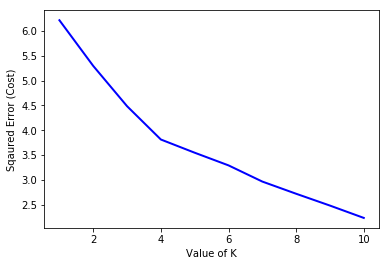

In [42]:
import matplotlib.pyplot as plt 
from matplotlib import style 
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline

bristol_grouped_clustering = bristol_grouped.drop('Coverage', 1)
cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500, random_state=126) 
    KM.fit(bristol_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='b', linewidth ='2') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() 

We can set k to 4 and create 4 clusters. We will need to make sure same random state that was used while calculating k value is used when running clustering algorithm

### Let us run the clustering algorithm on the dataset

In [43]:
# set number of clusters
kclusters = 4



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=126).fit(bristol_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 0, 3, 0, 0, 0, 0, 0, 0], dtype=int32)

We will need a new dataframe with the cluster labels and top 10 venues. This is achieved below

In [44]:
coverage_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
bristol_merged = df_latlong_merged_fin

# merge df_latlong_merged_fin with coverage_venues_sorted to add latitude/longitude for each coverage area
bristol_merged = bristol_merged.join(coverage_venues_sorted.set_index('Coverage'), on='Coverage')

Finally, let's visualize the resulting clusters

In [45]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bristol_merged['Latitude'], bristol_merged['Longitude'], bristol_merged['Coverage'], bristol_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters       

### Lets examine the 4 clusters generated

### Cluster 1

In [46]:
bristol_merged.loc[bristol_merged['Cluster Labels'] == 0, bristol_merged.columns[[0, 2] + list(range(6, bristol_merged.shape[1]))]]

,Postcode district,Coverage,count_venue,count_hotel,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BS1,"Bristol city centre, Redcliffe",100,1,0,Pub,Café,Coffee Shop,Bar,Indian Restaurant,Italian Restaurant,Restaurant,Music Venue,Steakhouse,Asian Restaurant
1,BS2,"Kingsdown, St Paul's, St Phillip's, St Agnes",100,5,0,Pub,Café,Hotel,Sandwich Place,Bar,Coffee Shop,Gym / Fitness Center,Music Venue,Burger Joint,Brewery
2,BS3,"Bedminster, Southville, Bower Ashton, part of ...",74,1,0,Pub,Coffee Shop,Pizza Place,Café,Bar,Pharmacy,Art Gallery,Grocery Store,Indian Restaurant,Train Station
3,BS4,"Brislington, Knowle, Knowle West, St Anne's, p...",18,0,0,Bar,Café,Supermarket,Pub,Coffee Shop,Sandwich Place,Furniture / Home Store,Fish & Chips Shop,Outdoor Supply Store,Pizza Place
4,BS5,"Easton, St George, Redfield, Whitehall, Eastvi...",19,0,0,Pub,Café,Grocery Store,Convenience Store,Deli / Bodega,Fast Food Restaurant,Park,Train Station,Rental Car Location,Paper / Office Supplies Store
5,BS6,"Cotham, Redland, Montpelier, Westbury Park, St...",94,0,0,Pub,Café,Coffee Shop,Pizza Place,Bar,Thai Restaurant,Gastropub,Grocery Store,Restaurant,Italian Restaurant
6,BS7,"Bishopston, Horfield, part of Filton, Lockleaz...",28,0,0,Pub,Café,Supermarket,Convenience Store,Coffee Shop,Gym / Fitness Center,Pizza Place,Rental Car Location,Chinese Restaurant,Middle Eastern Restaurant
7,BS8,"Clifton, Failand, Hotwells, Leigh Woods",84,2,0,Pub,Café,Bar,Pizza Place,Park,Italian Restaurant,Zoo Exhibit,Hotel,Art Gallery,Coffee Shop
8,BS9,"Coombe Dingle, Sneyd Park, Stoke Bishop, Westb...",15,0,0,Grocery Store,Coffee Shop,Park,Shopping Mall,Lounge,Event Service,Restaurant,Bakery,Café,Indian Restaurant
9,BS10,"Brentry, Henbury, Southmead, part of Westbury...",8,0,0,Gym / Fitness Center,Grocery Store,Soccer Field,Supermarket,Business Service,Fast Food Restaurant,Zoo Exhibit,Falafel Restaurant,Flower Shop,Fish & Chips Shop


### Cluster 2

In [47]:
bristol_merged.loc[bristol_merged['Cluster Labels'] == 1, bristol_merged.columns[[0, 2] + list(range(6, bristol_merged.shape[1]))]]

,Postcode district,Coverage,count_venue,count_hotel,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,BS40,"Chew Valley, Chew Magna, Chew Stoke, Wrington",1,0,1,Café,Zoo Exhibit,Fountain,Food & Drink Shop,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farm,Falafel Restaurant


In [48]:
#[m]# Cluster 3

In [49]:
bristol_merged.loc[bristol_merged['Cluster Labels'] == 2, bristol_merged.columns[[0, 2] + list(range(6, bristol_merged.shape[1]))]]

,Postcode district,Coverage,count_venue,count_hotel,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,BS35,"Alveston, Rudgeway, Severn Beach, Pilning, Tho...",2,0,2,Golf Course,Hardware Store,English Restaurant,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farm,Falafel Restaurant,Event Service
34,BS41,"Long Ashton, Dundry",3,0,2,Construction & Landscaping,Massage Studio,Golf Course,Zoo Exhibit,Falafel Restaurant,Food & Drink Shop,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant


### Cluster 4

In [50]:
bristol_merged.loc[bristol_merged['Cluster Labels'] == 3, bristol_merged.columns[[0, 2] + list(range(6, bristol_merged.shape[1]))]]

,Postcode district,Coverage,count_venue,count_hotel,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,BS25,"Churchill, Winscombe, Sandford, Shipham",6,0,3,Pub,Home Service,Café,Athletics & Sports,Falafel Restaurant,Food & Drink Shop,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant
21,BS26,"Axbridge, Compton Bishop, Loxton",3,0,3,Pub,Food,Gas Station,Falafel Restaurant,Food & Drink Shop,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farm,Event Service
32,BS39,"Clutton, Temple Cloud",1,0,3,Pub,Fountain,Food & Drink Shop,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farm,Falafel Restaurant,Event Service


## 5. Results and Discussion <a name="results"></a>

We have managed to segment and cluster Bristol city into 4 clusters using K-means. Examining the clusters we notice that:
1. Cluster 1 is busy city centre area/similar areas as it is evident from the high venue_counts in these rows. These are also the areas that have lots of cafe's, restaurants, tourist places etc. 
2. Clusters 2 3 and 4 are not so busy and are outside the main city region with a mix of Golf course, pub, restaurants etc. 

If we look at the count_hotel column in these clusters we can see that clusters 2, 3 and 4 have no entry. These coverage areas could be good candidates for building a new hotel. However, looking at the map these are not central to city so, stakeholders will have to think if there will be enough demand in these areas. Cluster 1 on the other hand has a few hotels, but based on the high demand, it may be a good option to open one here. Being well connected by train, air and road helps to support this notion.

## 6. Conclusion <a name="conclusion"></a>

The main purpose of the project was to help identify suitable areas in Bristol where a client can open a Hotel. We have used foursquare api to identify venues in each of the areas and used that to get count of hotels in each of the areas. We identified the best k that can be used to cluster the venue data and then applied the algorithm to form 4 clusters. Analysis of these 4 clusters provided some insights to so that any one willing to approach this problem can use this project as a starting point.<br />
This was an attempt to collect readily available information and come up with best available options. This project can be enhanced by analysing additional points like: 
1. Number of hotels in each area
2. Distance between each of them
3. Average price of rooms in a given area
4. What facilities are being planned to be included in the hotel etc